**Binome :**
* LOUAHADJ Aniss
* LANGLADE Alexandre

# TP 2: Neural networks (2)

## 0. Introduction and preliminaries

In this practical session, we will explore convolutional and recurrent neural network architectures. For the implementation of our neural network architectures, we will make use of Tensorflow and Keras. Tensorflow is Google's general machine learning framework, specifically designed for computations involving multi-dimensional arrays, which is particularly useful for neural networks. While the basic tensorflow interface is rather low-level, keras is a high-level library (part of the tensorflow package), that allows us to define neural network architectures in just a few lines of code. Additionally, we'll make use of matplotlib for a visual exploration of the dataset. The code below makes sure the necessary modules are loaded.

In [3]:
from IPython.display import clear_output
from ipywidgets import Output

In [4]:
!pip install livelossplot tqdm
clear_output()

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tqdm.keras import TqdmCallback

print(tf.__version__)

2.4.0


## 1. Classifying handwritten digits

In this exercise, we will once again use the MNIST dataset for handwritten digit classification. The dataset contains 70000 instances of handwritten digits (from 0 to 9) - of which 60000 are reserved for training and 10000 for testing.

### Convolutional neural networks: a reminder

In the last TP, we used a feedforward architecture for classifying the images of handwritten digits, in which all neurons in the former layer are fully connected to the neurons in the next layer. In this TP, we will perform the same classification task using a more evolved neural architecture: a convolutional neural network. A standard feedforward architecture has fully connected layers. In contrast, a convolutional layer is not fully connected; instead, we define a smaller weight matrix (e.g. 3x3 pixels), and we slide it over our images from left to right, and from top to bottom. This way, we apply the same weight matrix to every individual position in the image - which allows us to discover local features in the image that will be useful for the final classification. A convolutional layer generally defines several weight matrices, called `feature maps' or `filters', which are all applied to the image.  Each individual filter allows us to discover a different feature. A graphical representation of a convolutional network is give in the figure below.

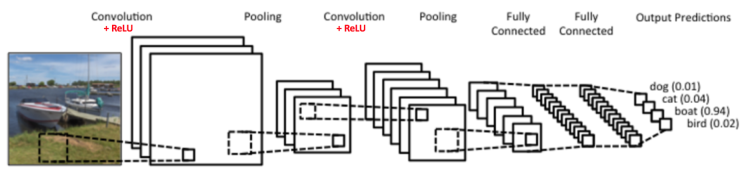

Note that we can have a sequence of several convolutional layers within a deep neural network. At each level in such a deep convolutional neural network, we are able to discover informative features that help with the final classification.


In a convolutional neural network, convolutional layers are often combined with pooling layers. Pooling layers also consist of a window that slides over the representation. At each position, we only keep the maximum value within the window. This allows us to reduce the size of the representation, by only keeping the most important value. A graphical representation of the pooling operation is given in the figure below.

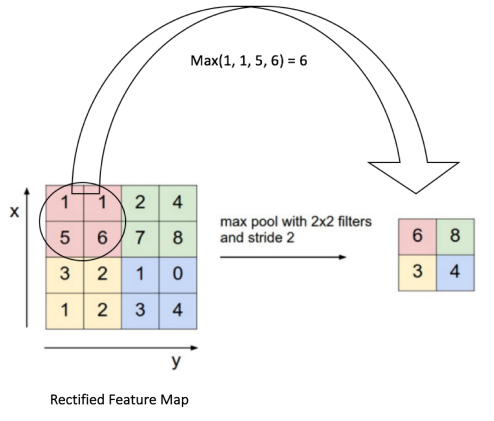

The final layers in a convolutional architecture are generally fully connected, which allows us to do the final classification.

### Load the MNIST data

 You can load the dataset using the code below (just like we did in the previous TP).

In [13]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Define pixel sizes of image (28x28)
(img_rows, img_cols) = (train_images.shape[1], train_images.shape[2])

The data is loaded into four Numpy-arrays:

* `train_images` and `train_labels` contains the data used for training the model
* `test_images` and `test_labels` contains the data used for _evaluating_ the performance of the trained model

The images are 28x28 NumPy arrays (matrices), with pixel values ranging from 0 to 255. The labels are an array of integers – ranging from 0 to 9 – where each number corresponds to the digit represented in the corresponding image.

The images in the dataset are represented by 28x28 matrices, but convolutional layers take as input three-dimensional arrays, where the extra dimension represents image "channels" (for representing color information). Our dataset contains grayscale images, which have only one channel, so our images will be converted to 28x28x1 arrays. Our three-dimensional image representations are then stacked together, which gives us a 4-dimensional array of 60000x28x28x1 for the training set, and 10000x28x28x1 for the test set.

In [14]:
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

Verify the shape of the variables and the number of samples:

In [6]:
print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


Again, in order to efficiently process the data, it is best to normalize the scores to the interval [0,1]. To do so, you can just divide the values by 255. Both the training set and the testing set need to be preprocessed in the same way.

In [7]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

### Model architecture

We are now ready to define our network. Our first layer is a convolutional layer with a window size of 3x3 pixels. The convolutional layer consists of a single filter (1). Next, we have a maximum pooling layer with a window size of 2x2 pixels. The representation is flattened into a vector, so it can be propagated into a dense layer. Our pre-final layer is a dense layer with a hidden size of 20. And our final layer is a dense layer of size num_classes with softmax, which yields a probability distribution over our class labels.

In [99]:
model = keras.Sequential([
    keras.layers.Conv2D(5, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

Once our model is defined, we compile it for efficient execution. This includes the definition of the training loss, the optimizer and the metrics we want to evaluate on.

In [100]:
opt=opt = keras.optimizers.Nadam(
    learning_rate=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

A model summary allows us to inspect our model architecture, together with the various output shape after each layer, and the number of parameters in each layer.

In [101]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 5)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 980)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               98100     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1010      
Total params: 99,160
Trainable params: 99,160
Non-trainable params: 0
_________________________________________________________________


We can now fit our model to the data. 10% of the data is reserved for validation.

In [102]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

from livelossplot.inputs.tf_keras import PlotLossesCallback
from typing import Dict
class PLK(PlotLossesCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch: int, logs: Dict[str, float]):
        with PLOT_CONTEXT:
            super().on_epoch_end(epoch, logs)

Output()

In [103]:
history = model.fit(train_images, train_labels,
          batch_size=64,
          epochs=3,
          verbose=0,
          validation_split=0.1,
          callbacks=[PLK(), TqdmCallback()])

When we are happy with our final model choice (architecture and hyperparameters), we can test its performance on the test set.

In [104]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08050382882356644
Test accuracy: 0.9742000102996826


In [105]:
predictions = model.predict(test_images)

In [106]:
def plot_image(i, predictions_array, true_label, img, class_names=None):
    if class_names == None:
        class_names = range(len(predictions_array))
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


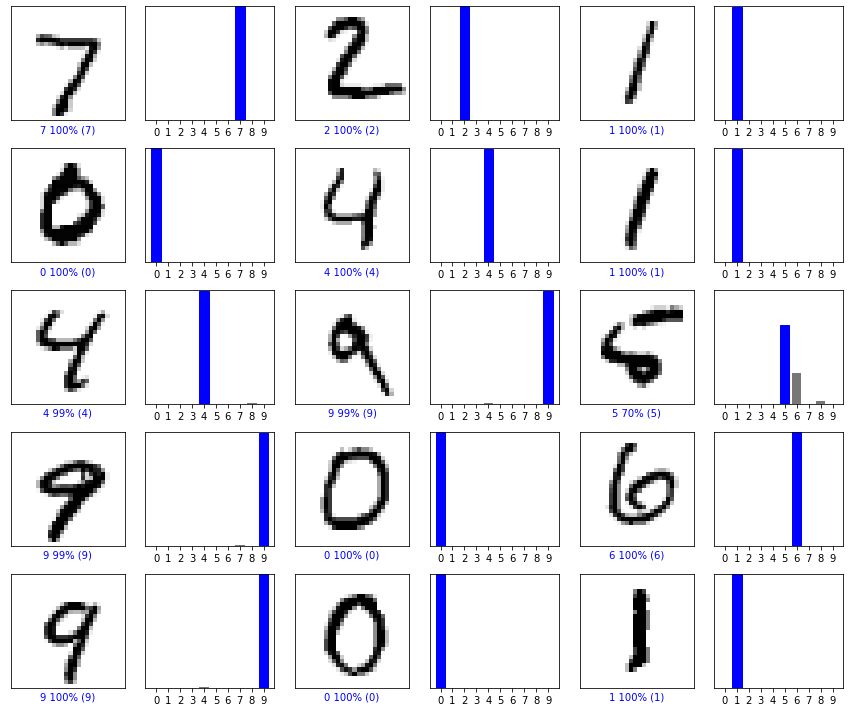

In [107]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images[:,:,:,0])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


### Exercise 1
Try to improve the performance of the neural network. With regard to the convolutional architecture, you could try to:
* increase the number of filters in the convolutional layer
* add a second convolutional and pooling layer

Also think about the possible improvements we have explored in the
former practical session.

### Réponses 
* **Modification de l'architecture et des hyperparamètres**
Nous décidons de garder les fonctions d'activation "relu". En effet, nous avons vu dans notre précedent TP que c'était les fonctions d'activation avec lesquelles nous avions un meilleure score. 
Nous avons testé trois optimizers parmi ceux avec lesquels nous avions les meilleurs résultats au prédent TP : SGD, Nadam et RMSprop.

|Optimizer |Précision à la validation |Fonction de perte à la validation|
|:-:|:-:|:-:|
|SGD|0.922|0.261|
|Nadam|0.944|0.189|
|RMSprop|0.936|0.214|

Nous décidons de garder l'optimizer Nadam compte tenu des résultats.

Nous tentons par la suites différentes valeurs de neurones pour l'avant-dernière couche.

|Nombre de neurones |Précision à la validation |Fonction de perte à la validation|
|:-:|:-:|:-:|
|20|0.944|0.189|
|50|0.962|0.133|
|100|0.967|0.114|
|1000|0.978|0.0772|

Nous décidons de garder une avant-dernière couche cachée de 100 neurones afin de limiter les temps de calculer tout en maximisant la précision.

* **Modification du nombre de filtres dans la couche convolutionnelle**
Nous décidons ensuite de modifier le nombres de filtres présents dans la couche convolutionnelle de notre model.

|Nombre de filtres |Précision à la validation |Fonction de perte à la validation|
|:-:|:-:|:-:|
|1|0.967|0.114|
|2|0.974|0.097|
|3|0.978|0.0798|
|4|0.978|0.0768|
|5|0.981|0.0713|

Après avoir testé deux fois chaque valeur nous décidons de garder une couche convolutionnelle à 5 filtres. C'est en effet avec ce chiffre que nous avons la meilleure précision pour un nombre relativement petit de filtres ainsi que la fonction de perte la plus basse.

* **Ajout d'une couche convolutionnelle et de pooling**
Par la suite, nous décidons d'ajouter une seconde couche convolutionnelle ainsi qu'une seconde couche de pooling. Là encore, nous testons différentes valeurs de filtres afin de maximiser notre précision.

|Nombre de filtres |Précision à la validation |Fonction de perte à la validation|
|:-:|:-:|:-:|
|2|0.969|0.1|
|3|0.972|0.0915|
|4|0.978|0.0791|
|5|0.982|0.0698|
|6|0.981|0.0733|

Nous remarquons que pour un faible nombre de filtres sur la seconde couche convolutionnelle nous avons tendance à impacter négativement la précision de notre réseau de neurones. Avec un nombre plus élevé de filtres nous remarquons qu'il n'y a quasiment aucune différence avec l'ajout de cette seconde couche. Nous choisissons donc de la supprimer.

En évaluant notre réseau de neurone avec les données de test nous obtenons une précision de 97.42%. Ce score est excellent. Des chiffres que nous n'arrivions pas à distinguer nous même sont reconnus correctement.

## 2. Object recognition (reconnaissance d’objets)

### Load CIFAR10 data

Load the CIFAR10 dataset (for object recognition) using the function below.

In [70]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [71]:
print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

train_images shape: (50000, 32, 32, 3)
test_images shape: (10000, 32, 32, 3)
50000 train samples
10000 test samples


In order to have a single vector of labels, we flatten both label vectors.

In [72]:
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

Each class label is represented as a number from 1 to 10. We therefore define an array of class names, so that image labels are interpretable when we plot them.

In [73]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The function below plots the first 25 images of the dataset.

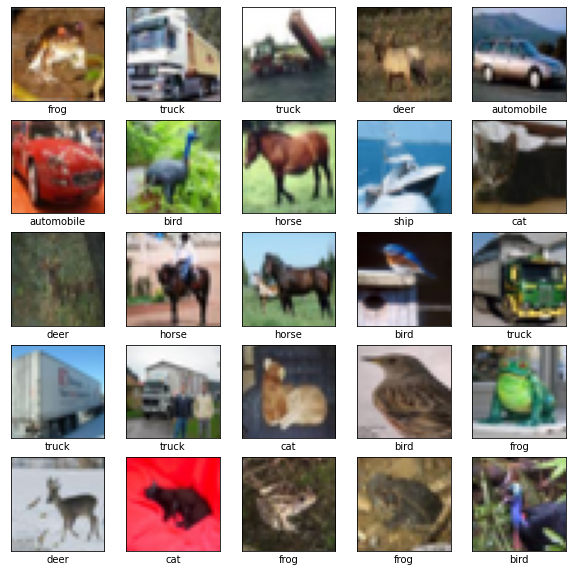

In [74]:
train_labels = train_labels.flatten()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Exercise 2

* **Exercise 7**: Build an appropriate **convolutional** neural network architecture for object recognition using Keras's `Sequential` module. Compile the model, using an appropriate loss function, optimization procedure, and metric. Train the model on the training set and evaluate it on the test set. What score do you achieve? Try to improve upon your model.

### Réponse à l'exercice 2


**Architecture 1 :**

In [90]:
## Exercise 7

input_shape = (32,32,3)

model2 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    
    keras.layers.Dense(10, activation='softmax')
])

In [91]:
opt=opt = keras.optimizers.Nadam(
    learning_rate=0.001)
model2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 512)       

In [93]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

from livelossplot.inputs.tf_keras import PlotLossesCallback
from typing import Dict
class PLK(PlotLossesCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch: int, logs: Dict[str, float]):
        with PLOT_CONTEXT:
            super().on_epoch_end(epoch, logs)

Output()

In [94]:
history = model2.fit(train_images, train_labels,
          batch_size=64,
          epochs=3,
          verbose=0,
          validation_split=0.1,
          callbacks=[PLK(), TqdmCallback()])

In [95]:
score = model2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.94119793176651
Test accuracy: 0.682699978351593


**Architecture 2 :**

In [99]:
model3 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),  
    keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),  
    keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape,
                        padding="same"),  
    keras.layers.Conv2D(64, kernel_size=(3, 3),
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation='softmax')
])

In [100]:
opt=opt = keras.optimizers.Nadam(
    learning_rate=0.001)
model3.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 512)       

In [102]:
history = model3.fit(train_images, train_labels,
          batch_size=64,
          epochs=3,
          verbose=0,
          validation_split=0.1,
          callbacks=[PLK(), TqdmCallback()])

In [103]:
score = model2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.94119793176651
Test accuracy: 0.682699978351593


### Test des différentes architectures

* **Test de la première architecture**

Afin de définir l'architecture de notre réseau de neurones, nous avons tout d'abord fait plusieurs recherche sur les architectures existantes afin de les tester. Après avoir préparer les entrées de notres model (autrement dit modifié nos images en modifiant le code après le téléchargement des données), notre choix s'est porté sur l'architecture representée sur l'image suivante :

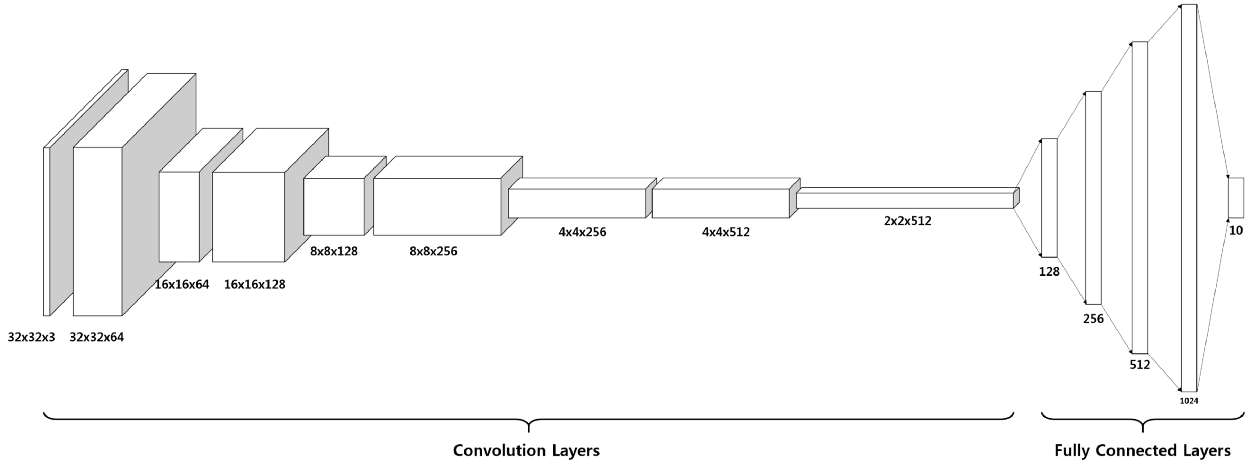

Suite à l'entrainement de ce model dont le code est donné plus haut, nous avons eu pour résultats à l'entrainement :
* val_loss=0.893, val_accuracy=0.686

A l'évaluation de notre model nous avons eu pour résultats :
* Test loss: 0.94119793176651, Test accuracy: 0.682699978351593

* **Test de la deuxième architecture**

Nous avons ensuite d'essayer une architecture plus simple et dont le temps de traitement est inférieur. 
Suite à l'entrainement de ce nouveau model dont le code est également donné plus haut, nous avons eu pour résultats à l'entrainement :
* val_loss=1.24, val_accuracy=0.551

A l'évaluation de notre model nous avons eu pour résultats :
* Test loss: 0.94119793176651, Test accuracy: 0.682699978351593

## Conclusion :

Cette dernière partie nous demanderait énormément de temps afin de réaliser un model possédant une architecture nous offrant un meilleur résultat. Cependant, les images de la base Cifar10 étant trop complexes et n'ayant pas suffisamment de temps nous choisirons ici de conserver l'architecture 1.